
# Implementing DPS

In this tutorial, we will go over the steps in the Diffusion Posterior Sampling (DPS) algorithm introduced in
[Chung et al.](https://arxiv.org/abs/2209.14687) The full algorithm is implemented in
:meth:`deepinv.sampling.DPS`.


-----------------------------
Let us ``import`` the relevant packages, and load a sample
image of size 64x64. This will be used as our ground truth image.
<div class="alert alert-info"><h4>Note</h4><p>We work with an image of size 64x64 to reduce the computational time of this example.
          The algorithm works best with images of size 256x256.</p></div>




In [1]:
import numpy as np
import torch

import deepinv as dinv
from deepinv.utils.plotting import plot
from deepinv.optim.data_fidelity import L2
from deepinv.utils.demo import load_url_image, get_image_url
from tqdm import tqdm  # to visualize progress

device = dinv.utils.get_freer_gpu() if torch.cuda.is_available() else "cpu"

url = get_image_url("butterfly.png")

x_true = load_url_image(url=url, img_size=64).to(device)
x = x_true.clone()

c:\Users\jbhim\miniconda3\envs\altegrad\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Selected GPU 0 with 5816 MB free memory 


In this tutorial we consider random inpainting as the inverse problem, where the forward operator is implemented
in :meth:`deepinv.physics.Inpainting`. In the example that we use, 90% of the pixels will be masked out randomly,
and we will additionally have Additive White Gaussian Noise (AWGN) of standard deviation  12.75/255.



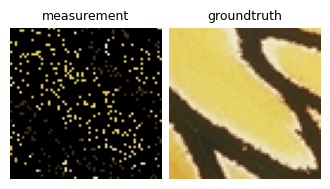

In [2]:
sigma = 12.75 / 255.0  # noise level

physics = dinv.physics.Inpainting(
    tensor_size=(3, x.shape[-2], x.shape[-1]),
    mask=0.1,
    pixelwise=True,
    device=device,
)

y = physics(x_true)

imgs = [y, x_true]
plot(
    imgs,
    titles=["measurement", "groundtruth"],
)

## Diffusion model loading

We will take a pre-trained diffusion model that was also used for the DiffPIR algorithm, namely the one trained on
the FFHQ 256x256 dataset. Note that this means that the diffusion model was trained with human face images,
which is very different from the image that we consider in our example. Nevertheless, we will see later on that
``DPS`` generalizes sufficiently well even in such case.



In [3]:
model = dinv.models.DiffUNet(large_model=False).to(device)

Downloading: "https://huggingface.co/deepinv/diffunet/resolve/main/diffusion_ffhq_10m.pt?download=true" to C:\Users\jbhim/.cache\torch\hub\checkpoints\diffusion_ffhq_10m.pt
100%|██████████| 357M/357M [01:20<00:00, 4.66MB/s] 


## Define diffusion schedule

We will use the standard linear diffusion noise schedule. Once $\beta_t$ is defined to follow a linear schedule
that interpolates between $\beta_{\rm min}$ and $\beta_{\rm max}$,
we have the following additional definitions:
$\alpha_t := 1 - \beta_t$, $\bar\alpha_t := \prod_{j=1}^t \alpha_j$.
The following equations will also be useful
later on (we always assume that $\mathbf{\epsilon} \sim \mathcal{N}(\mathbf{0}, \mathbf{I})$ hereafter.)

\begin{align}\mathbf{x}_t = \sqrt{\beta_t}\mathbf{x}_{t-1} + \sqrt{1 - \beta_t}\mathbf{\epsilon}

          \mathbf{x}_t = \sqrt{\bar\alpha_t}\mathbf{x}_0 + \sqrt{1 - \bar\alpha_t}\mathbf{\epsilon}\end{align}

where we use the reparametrization trick.



In [4]:
num_train_timesteps = 1000  # Number of timesteps used during training


def get_betas(
    beta_start=0.1 / 1000, beta_end=20 / 1000, num_train_timesteps=num_train_timesteps
):
    betas = np.linspace(beta_start, beta_end, num_train_timesteps, dtype=np.float32)
    betas = torch.from_numpy(betas).to(device)

    return betas


# Utility function to let us easily retrieve \bar\alpha_t
def compute_alpha(beta, t):
    beta = torch.cat([torch.zeros(1).to(beta.device), beta], dim=0)
    a = (1 - beta).cumprod(dim=0).index_select(0, t + 1).view(-1, 1, 1, 1)
    return a


betas = get_betas()

## The DPS algorithm

Now that the inverse problem is defined, we can apply the DPS algorithm to solve it. The DPS algorithm is
a diffusion algorithm that alternates between a denoising step, a gradient step and a reverse diffusion sampling step.
The algorithm writes as follows, for $t$ decreasing from $T$ to $1$:

\begin{align}\begin{equation*}
        \begin{aligned}
        \widehat{\mathbf{x}}_{t} &= \denoiser{\mathbf{x}_t}{\sqrt{1-\overline{\alpha}_t}/\sqrt{\overline{\alpha}_t}}
        \\
        \mathbf{g}_t &= \nabla_{\mathbf{x}_t} \log p( \widehat{\mathbf{x}}_{t}(\mathbf{x}_t) | \mathbf{y} ) \\
        \mathbf{\varepsilon}_t &= \mathcal{N}(0, \mathbf{I}) \\
        \mathbf{x}_{t-1} &= a_t \,\, \mathbf{x}_t
        + b_t \, \, \widehat{\mathbf{x}}_t
        + \tilde{\sigma}_t \, \, \mathbf{\varepsilon}_t + \mathbf{g}_t,
        \end{aligned}
        \end{equation*}\end{align}

where $\denoiser{\cdot}{\sigma}$ is a denoising network for noise level $\sigma$,
$\eta$ is a hyperparameter, and the constants $\tilde{\sigma}_t, a_t, b_t$ are defined as

\begin{align}\begin{equation*}
        \begin{aligned}
          \tilde{\sigma}_t &= \eta \sqrt{ (1 - \frac{\overline{\alpha}_t}{\overline{\alpha}_{t-1}})
          \frac{1 - \overline{\alpha}_{t-1}}{1 - \overline{\alpha}_t}} \\
          a_t &= \sqrt{1 - \overline{\alpha}_{t-1} - \tilde{\sigma}_t^2}/\sqrt{1-\overline{\alpha}_t} \\
          b_t &= \sqrt{\overline{\alpha}_{t-1}} - \sqrt{1 - \overline{\alpha}_{t-1} - \tilde{\sigma}_t^2}
          \frac{\sqrt{\overline{\alpha}_{t}}}{\sqrt{1 - \overline{\alpha}_{t}}}
        \end{aligned}
        \end{equation*}\end{align}




## Denoising step

The first step of DPS consists of applying a denoiser function to the current image $\mathbf{x}_t$,
with standard deviation $\sigma_t = \sqrt{1 - \overline{\alpha}_t}/\sqrt{\overline{\alpha}_t}$.

This is equivalent to sampling $\mathbf{x}_t \sim q(\mathbf{x}_t|\mathbf{x}_0)$, and then computing the
posterior mean.




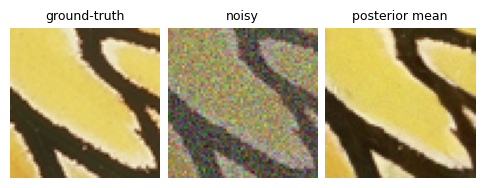

In [5]:
t = torch.ones(1, device=device) * 50  # choose some arbitrary timestep
at = compute_alpha(betas, t.long())
sigmat = (1 - at).sqrt() / at.sqrt()

x0 = x_true
xt = x0 + sigmat * torch.randn_like(x0)

# apply denoiser
x0_t = model(xt, sigmat)

# Visualize
imgs = [x0, xt, x0_t]
plot(
    imgs,
    titles=["ground-truth", "noisy", "posterior mean"],
)

## DPS approximation

In order to perform gradient-based **posterior sampling** with diffusion models, we have to be able to compute
$\nabla_{\mathbf{x}_t} \log p(\mathbf{x}_t|\mathbf{y})$. Applying Bayes rule, we have

\begin{align}\nabla_{\mathbf{x}_t} \log p(\mathbf{x}_t|\mathbf{y}) = \nabla_{\mathbf{x}_t} \log p(\mathbf{x}_t)
          + \nabla_{\mathbf{x}_t} \log p(\mathbf{y}|\mathbf{x}_t)\end{align}

For the former term, we can simply plug-in our estimated score function as in Tweedie's formula. As the latter term
is intractable, DPS proposes the following approximation (for details, see Theorem 1 of
[Chung et al.](https://arxiv.org/abs/2209.14687)

\begin{align}\nabla_{\mathbf{x}_t} \log p(\mathbf{x}_t|\mathbf{y}) \approx \nabla_{\mathbf{x}_t} \log p(\mathbf{x}_t)
          + \nabla_{\mathbf{x}_t} \log p(\mathbf{y}|\widehat{\mathbf{x}}_{t})\end{align}

Remarkably, we can now compute the latter term when we have Gaussian noise, as

\begin{align}\log p(\mathbf{y}|\hat{\mathbf{x}}_{t}) =
      -\frac{\|\mathbf{y} - A\widehat{\mathbf{x}}_{t}\|_2^2}{2\sigma_y^2}.\end{align}

Moreover, taking the gradient w.r.t. $\mathbf{x}_t$ can be performed through automatic differentiation.
Let's see how this can be done in PyTorch. Note that when we are taking the gradient w.r.t. a tensor,
we first have to enable the gradient computation by ``tensor.requires_grad_()``

<div class="alert alert-info"><h4>Note</h4><p>The diffPIR algorithm assumes that the images are in the range [-1, 1], whereas standard denoisers
          usually output images in the range [0, 1]. This is why we rescale the images before applying the steps.</p></div>



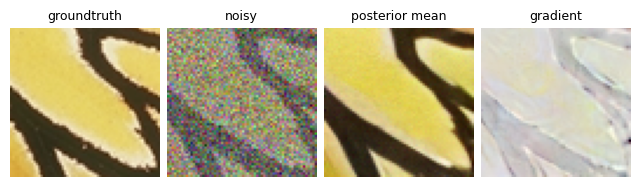

In [6]:
x0 = x_true * 2.0 - 1.0  # [0, 1] -> [-1, 1]

data_fidelity = L2()

# xt ~ q(xt|x0)
i = 200  # choose some arbitrary timestep
t = (torch.ones(1) * i).to(device)
at = compute_alpha(betas, t.long())
xt = at.sqrt() * x0 + (1 - at).sqrt() * torch.randn_like(x0)

# DPS
with torch.enable_grad():
    # Turn on gradient
    xt.requires_grad_()

    # normalize to [0,1], denoise, and rescale to [-1, 1]
    x0_t = model(xt / 2 + 0.5, (1 - at).sqrt() / at.sqrt() / 2) * 2 - 1
    # Log-likelihood
    ll = data_fidelity(x0_t, y, physics).sqrt().sum()
    # Take gradient w.r.t. xt
    grad_ll = torch.autograd.grad(outputs=ll, inputs=xt)[0]

# Visualize
imgs = [x0, xt, x0_t, grad_ll]
plot(
    imgs,
    titles=["groundtruth", "noisy", "posterior mean", "gradient"],
)

## DPS Algorithm

As we visited all the key components of DPS, we are now ready to define the algorithm. For every denoising
timestep, the algorithm iterates the following

1. Get $\hat{\mathbf{x}}$ using the denoiser network.
2. Compute $\nabla_{\mathbf{x}_t} \log p(\mathbf{y}|\hat{\mathbf{x}}_t)$ through backpropagation.
3. Perform reverse diffusion sampling with DDPM(IM), corresponding to an update with $\nabla_{\mathbf{x}_t} \log p(\mathbf{x}_t)$.
4. Take a gradient step with $\nabla_{\mathbf{x}_t} \log p(\mathbf{y}|\hat{\mathbf{x}}_t)$.

There are two caveats here. First, in the original work, DPS used DDPM ancestral sampling. As the [DDIM sampler](https://arxiv.org/abs/2010.02502)) is a generalization of DDPM in a sense that it retrieves DDPM when
$\eta = 1.0$, here we consider DDIM sampling.
One can freely choose the $\eta$ parameter here, but since we will consider 1000
neural function evaluations (NFEs),
it is advisable to keep it $\eta = 1.0$. Second, when taking the log-likelihood gradient step,
the gradient is weighted so that the actual implementation is a static step size times the $\ell_2$
norm of the residual:

\begin{align}\nabla_{\mathbf{x}_t} \log p(\mathbf{y}|\hat{\mathbf{x}}_{t}(\mathbf{x}_t)) \simeq
          \rho \nabla_{\mathbf{x}_t} \|\mathbf{y} - \mathbf{A}\hat{\mathbf{x}}_{t}\|_2\end{align}

With these in mind, let us solve the inverse problem with DPS!



<div class="alert alert-info"><h4>Note</h4><p>We only use 200 steps to reduce the computational time of this example. As suggested by the authors of DPS, the
  algorithm works best with ``num_steps = 1000``.</p></div>




100%|██████████| 200/200 [00:14<00:00, 13.94it/s]


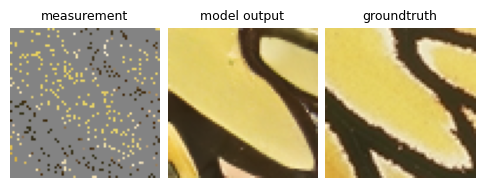

In [7]:
num_steps = 200

skip = num_train_timesteps // num_steps

batch_size = 1
eta = 1.0

seq = range(0, num_train_timesteps, skip)
seq_next = [-1] + list(seq[:-1])
time_pairs = list(zip(reversed(seq), reversed(seq_next)))

# measurement
x0 = x_true * 2.0 - 1.0
y = physics(x0.to(device))

# initial sample from x_T
x = torch.randn_like(x0)

xs = [x]
x0_preds = []

for i, j in tqdm(time_pairs):
    t = (torch.ones(batch_size) * i).to(device)
    next_t = (torch.ones(batch_size) * j).to(device)

    at = compute_alpha(betas, t.long())
    at_next = compute_alpha(betas, next_t.long())

    xt = xs[-1].to(device)

    with torch.enable_grad():
        xt.requires_grad_()

        # 1. denoising step
        # we call the denoiser using standard deviation instead of the time step.
        aux_x = xt / 2 + 0.5
        x0_t = 2 * model(aux_x, (1 - at).sqrt() / at.sqrt() / 2) - 1
        x0_t = torch.clip(x0_t, -1.0, 1.0)  # optional

        # 2. likelihood gradient approximation
        l2_loss = data_fidelity(x0_t, y, physics).sqrt().sum()

    norm_grad = torch.autograd.grad(outputs=l2_loss, inputs=xt)[0]
    norm_grad = norm_grad.detach()

    sigma_tilde = ((1 - at / at_next) * (1 - at_next) / (1 - at)).sqrt() * eta
    c2 = ((1 - at_next) - sigma_tilde**2).sqrt()

    # 3. noise step
    epsilon = torch.randn_like(xt)

    # 4. DDPM(IM) step
    xt_next = (
        (at_next.sqrt() - c2 * at.sqrt() / (1 - at).sqrt()) * x0_t
        + sigma_tilde * epsilon
        + c2 * xt / (1 - at).sqrt()
        - norm_grad
    )

    x0_preds.append(x0_t.to("cpu"))
    xs.append(xt_next.to("cpu"))

recon = xs[-1]

# plot the results
x = recon / 2 + 0.5
imgs = [y, x, x_true]
plot(imgs, titles=["measurement", "model output", "groundtruth"])

## Using DPS in your inverse problem
You can readily use this algorithm via the :meth:`deepinv.sampling.DPS` class.

::

      y = physics(x)
      model = dinv.sampling.DPS(dinv.models.DiffUNet(), data_fidelity=dinv.optim.L2())
      xhat = model(y, physics)


